### MSE - T-MachLe
# PW 04

{dorian.magnin, noemien.kocher}@master.hes-so.ch

## Exercice 1 Classification system

### a. Getting started

#### a) + b)

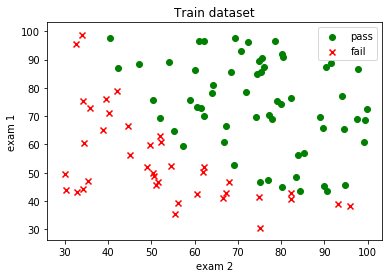

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from numpy.linalg import inv

dataset = pd.read_csv('ex1-data-train.csv',
                        header=0,
                        names=['x1', 'x2', 'y'])

x1 = dataset['x1'].values
x2 = dataset['x2'].values
y = dataset['y'].values
N = len(x1)

ones_x1 = [x1[i] for i in range(0, N) if y[i] == 1]
ones_x2 = [x2[i] for i in range(0, N) if y[i] == 1]

zero_x1 = [x1[i] for i in range(0, N) if y[i] == 0]
zero_x2 = [x2[i] for i in range(0, N) if y[i] == 0]

plt.scatter(ones_x1, ones_x2, marker="o", label="pass", color="green")
plt.scatter(zero_x1, zero_x2, marker="x", label="fail", color="red")
plt.legend()
plt.title("Train dataset")
plt.ylabel("exam 1")
plt.xlabel("exam 2")
plt.show()

#### c)

In [29]:
import random

def blindTest(x1, x2):
    test = random.random()
    return 1 if test > 0.5 else 0

#### d)


In [28]:
true_guess = 0
for i in range(0, len(x1)):
    guess = blindTest(x1[i], x2[i])
    if guess == y[i]:
        true_guess = true_guess + 1

print("Performance: ", true_guess/N)

Performance:  0.5151515151515151


### b. K-nn classifier

Nous remarquons que les meilleurs résultats sont avec un `k=2` ou `k=3`. Comme critère en cas d'égalité, nous prenons la catégorie du point le plus proche.

Pour le fun, nous avons fait varié le k jusqu'à `N`. On remarque que jusqu'environ 70 la performance est stable.

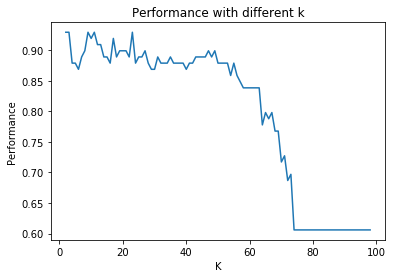

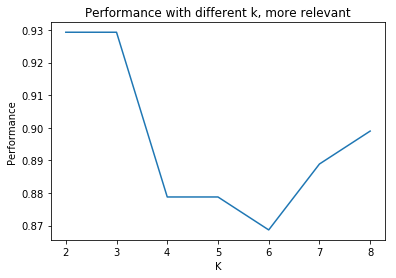

In [27]:
from sklearn.neighbors import NearestNeighbors

X = []
for i in range(0, N):
    X.append([x1[i], x2[i]])

def distEucl(point1, point2):
    return np.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)


max = N-1

dists, indices = NearestNeighbors(n_neighbors=max+1,
                                  algorithm='ball_tree',
                                  metric="euclidean").fit(X).kneighbors(X)


measures = []
ks = []

for k in range(2,max+1):
    
    true_guess = 0
    
    # Pour chaque point
    for i in range(0, N):
        fails = 0
        passs = 0
        # Pour chaque voisin du point
        for neighborI in indices[i][1:k]:
            if y[neighborI] == 0:
                fails = fails + 1
            else:
                passs = passs + 1
        if fails > passs:
            knnresult = 0
        elif fails == passs: # On pourrait choisir un autre critère
            knnresult = y[indices[i][1]]
        else:
            knnresult = 1
        if knnresult == y[i]:
            true_guess = true_guess + 1
    
    measures.append(true_guess/N)
    ks.append(k)
    #print("With k =", k)
    #print("Performance: ", true_guess/N)
    
#print("ks:", ks)
#print("measures: ", measures)
plt.plot(ks, measures)
plt.title("Performance with different k")
plt.xlabel("K")
plt.ylabel("Performance")
plt.show()

plt.plot(ks[:7], measures[:7])
plt.title("Performance with different k, more relevant")
plt.xlabel("K")
plt.ylabel("Performance")
plt.show()


### c. Bayes - Histogram

#### a) Compute the priors of both classes P(C0) and P(C1).

In [33]:
n_pass = 0
n_fail = 0
for i in range(0, N):
    if y[i] == 0:
        n_fail = n_fail + 1
    if y[i] == 1:
        n_pass = n_pass + 1

print("Prior pass: ", n_pass/N)
print("Prior fail: ", n_fail/N)

Prior pass:  0.6060606060606061
Prior fail:  0.3939393939393939


#### b) Compute histograms of x1 and x2 for each class (total of 4 histograms). Plot these histograms. Advice : use the numpy histogram(a,bins=’auto’) function.

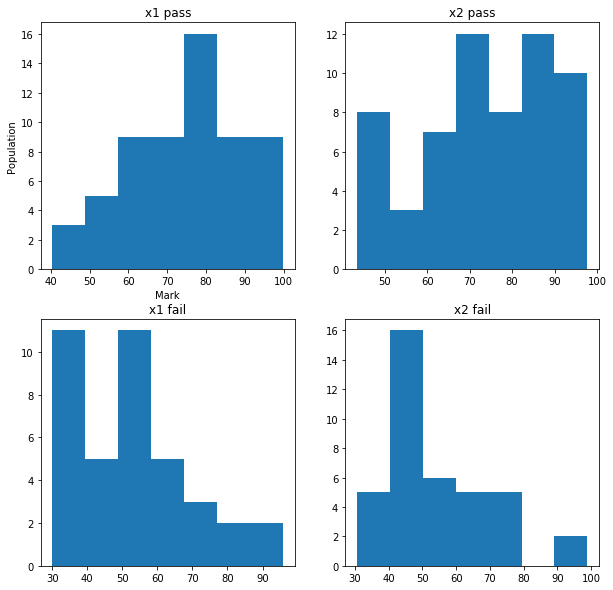

In [56]:
f1, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))

ax1.hist(ones_x1, bins='auto')
ax1.set_title("x1 pass")
ax1.set_ylabel("Population")
ax1.set_xlabel("Mark")
ax2.hist(ones_x2, bins='auto')
ax2.set_title("x2 pass")
ax3.hist(zero_x1, bins='auto')
ax3.set_title("x1 fail")
ax4.hist(zero_x2, bins='auto')
ax4.set_title("x2 fail")


plt.show()

#### c) Use the histograms to compute the likelihoods p(x1|C0), p(x1|C1), p(x2|C0) and p(x2|C1). For this define a function likelihoodHist(x,histValues,edgeValues) that returns the likelihood of x for a given histogram (defined by its values and bin edges as returned by the numpy histogram() function).

In [79]:
def likelihoodHist(x, histValues, edgeValues):
    for i in range(0, len(histValues)):
        if edgeValues[i] == x:
            return histValues[i]
        if edgeValues[i] >= x:
            return histValues[i-1]
    return 0
        
    
#histValues, edgeValues = np.histogram(ones_x1, bins='auto')
#for i in range(0, N):
#    print(likelihoodHist(x1[i], histValues, edgeValues))

#### d) Implement the classification decision according to Bayes rule and compute the performance of the system on the training set :
— using only feature x1
— using only feature x2
— using x1 and x2 making the naive Bayes hypothesis of feature independence, i.e.
p(X|Ck) = p(x1|Ck) · p(x2|Ck)
2
Exam 2 score x2
Which system is the best ?

In [82]:
def postProb(xi, histValues, edgeValues):
    return likelihoodHist(xi, histValues, edgeValues)

print("Only using feature 1")


for i in range(0, N):
    histValues, edgeValues = np.histogram(zero_x1, bins='auto')
    prob_fail = postProb(x1[i], histValues, edgeValues) 
    
    histValues, edgeValues = np.histogram(ones_x1, bins='auto')
    prob_pass = postProb(x1[i], histValues, edgeValues) 
    
    # Check la plus haute prob

Only using feature 1
